<a href="https://colab.research.google.com/github/pinballsurgeon/sweeping_analysis/blob/main/emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## installs

In [1]:
!pip install pytrends
!pip install joypy

  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16126 sha256=4aad7a876ca7bcf0ae58fdafd387321727792768a5359a2aad903ab03722b694
  Stored in directory: /root/.cache/pip/wheels/07/6f/5c/8174f98dec1bfbc7d5da4092854afcbcff4b26c3d9b66b5183
Successfully built pytrends


## imports

In [12]:
import pandas 

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 



In [3]:
# configurations
config_dict = { 'analysis_start_year'  : 2021
              , 'analysis_start_month' : 1
              , 'analysis_end_year'    : 2021
              , 'analysis_end_month'   : 2
              , 'analysis_country'     : 'US' }


# topics
topics_explicit = ['flipflops', 'pumpkin', 'waffle', 'turkey', 'chicken', 'peanuts', 'baseball', 'basketball', 'football', 'kite', 'ice cream', 'hotdog', 'rocket']



In [4]:
df_total = pandas.DataFrame()

for topic in topics_explicit:


  pytrend = TrendReq()
  pytrend.build_payload(kw_list=[topic], timeframe='today 5-y')
  df = pytrend.interest_over_time()


#  df = dailydata.get_daily_data( topic
#                               , config_dict['analysis_start_year']
#                               , config_dict['analysis_start_month']
#                               , config_dict['analysis_end_year']
#                               , config_dict['analysis_end_month']
#                               , geo = config_dict['analysis_country']
#                               , verbose = False )
  
  df_total[topic] = df[topic]

# drop nans
df_total = df_total.dropna()

In [5]:
# capture features
df_features = df_total[topics_explicit]

In [6]:
# normalize
df_features=(df_features-df_features.mean())/df_features.std()

In [7]:

# normalize it all history (meanly)
df_total = (df_total-df_total.mean())/df_total.std()
df_features_recent = df_total[df_total.index > '1/1/2010']

# normalize it recent history (meanly)
df_features_recent = (df_features_recent-df_features_recent.mean())/df_features_recent.std()

# group by week, average occurences
df_agg = df_features
df_agg_recent = df_features_recent


In [8]:
# populate us
df_stk=pandas.DataFrame()
globalst=[]

# navigate hierarchy, each combination of WEEKNUM and FLOWER
for col in df_agg:           # flower
    for val in df_agg.index.weekofyear: # weeknum
        
        
        # time sensitive
        fs_val = df_agg[col][val]                   # full spectrum
        
        # in cases of no recent
        try:
            fs_val_recent = df_agg_recent[col][val] # recent spectrum
        except:
            fs_val_recent = 0
        
        
        # at this combo of flower/weeknum, check which source is greater, as its our limiter
        if fs_val > fs_val_recent:
            fs_max = fs_val
            fs_min = fs_val_recent
            fs_max_src = 'full'
        else:
            fs_max = fs_val_recent
            fs_min = fs_val
            fs_max_src = 'recent'
        
        
        # if max frequency signal greater than 0
        #if fs_max > 0 or fs_min > 0:
        #if fs_max > 0:
        if fs_max > 0.1 and fs_min > 0.1:
            
            # secondary source counter
            sec_i=1
            
            
            # iterate through each instance of max bin occurence, determining number of weeks written
            for x in range(0,int(abs(fs_max) * 100)):
            
            
                # full source
                if fs_max_src == 'full':
                    
                    if sec_i < int(abs(fs_min) * 100):
                    
                        lst=[val, val, col]
                        globalst.append(lst)
                    
                    else:
                        
                        lst=[val, None, col]
                        globalst.append(lst)                    
                    
                # recent source
                if sec_i < int(abs(fs_min) * 100):
                    
                    lst=[val, val, col]
                    globalst.append(lst)
                    
                else:
                        
                    lst=[None, val, col]
                    globalst.append(lst)                     
                    
                    
                sec_i+=1
                #print(sec_i)
                #print(df_agg[col][val])
                #print(df_agg_recent[col][val])
                
                
                #lst=[val, col]
                globalst.append(lst)
       
    
        #df_stk=df_stk.append(lst)

df_flat = pandas.DataFrame(globalst
                      ,columns=['WeekNum'
                               ,'WeekNum_Rct'
                               ,'Flower_Tot'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


In [9]:
df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()
df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]
print(df_stats.columns)
df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

#df_stats['Name'] = '00' + str((df_stats['WeekNum mean']).astype(int)) #+ df_stats['Flower']
df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

i = 1
for index, row in df_stats.iterrows():
    #print(row['Flower'], row['Name'])
    df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])
    #df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])
    #df_flat['Flower'] = df_flat['Flower'].replace(row['Flower'], str(i) + row['Flower'])
    i+=1

print(df_flat)

Index(['Flower_Tot', 'WeekNum mean', 'WeekNum count', 'WeekNum_Rct mean',
       'WeekNum_Rct count'],
      dtype='object')
        WeekNum  WeekNum_Rct      Flower_Tot
0           9.0          9.0  2440 flipflops
1           9.0          9.0  2440 flipflops
2           9.0          9.0  2440 flipflops
3           9.0          9.0  2440 flipflops
4           9.0          9.0  2440 flipflops
...         ...          ...             ...
269818      5.0          5.0     4278 rocket
269819      5.0          5.0     4278 rocket
269820      5.0          5.0     4278 rocket
269821      NaN          5.0     4278 rocket
269822      NaN          5.0     4278 rocket

[269823 rows x 3 columns]


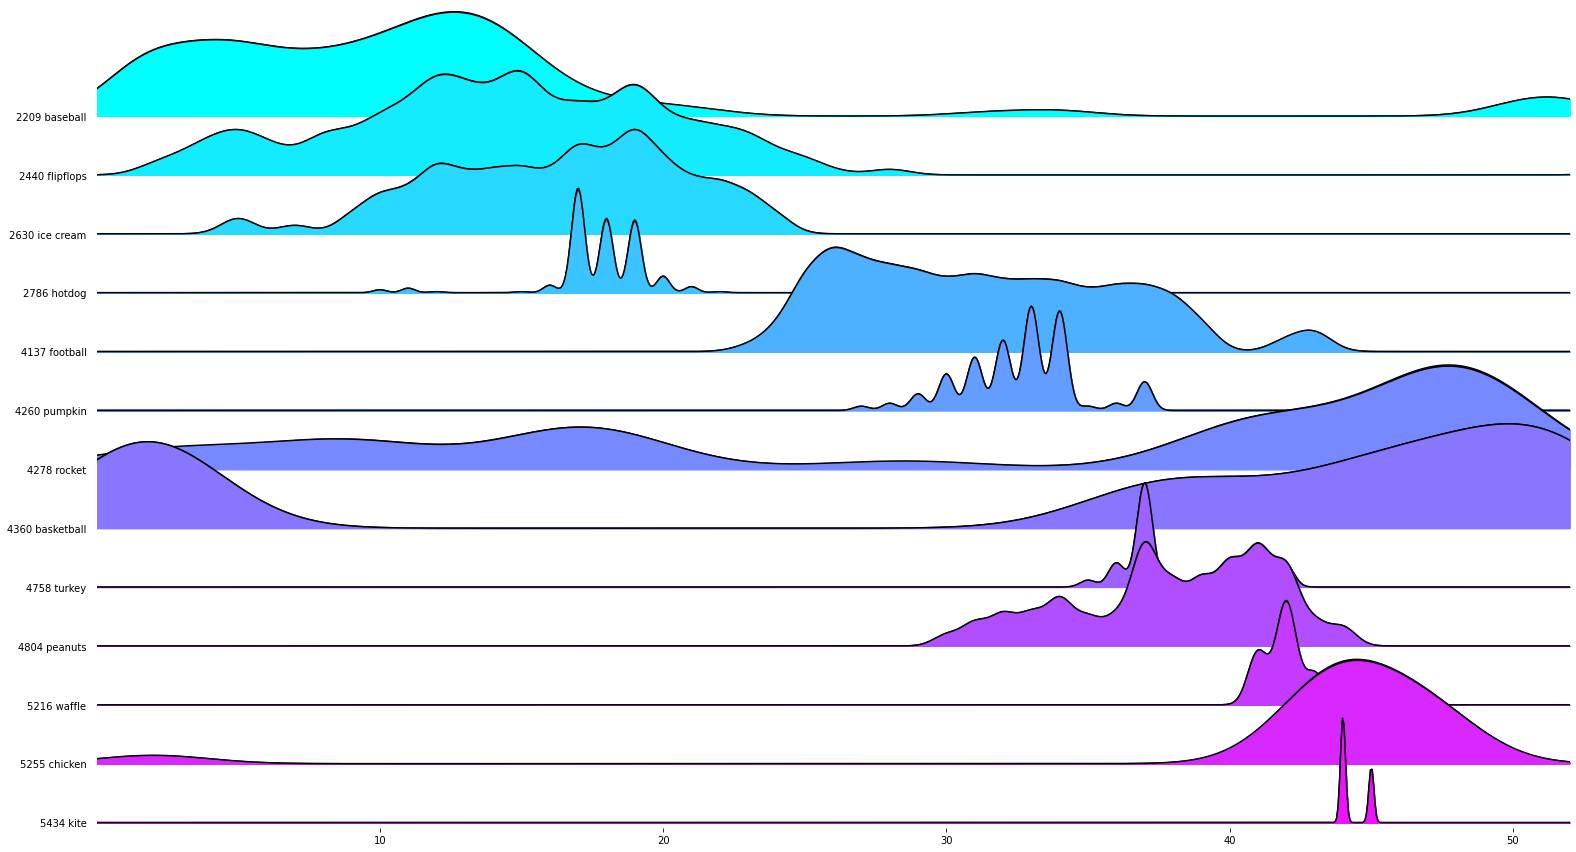

In [10]:
fig, axes = joypy.joyplot(df_flat
                          , column=['WeekNum', 'WeekNum_Rct']
                          , by='Flower_Tot'
                          , overlap=1.2
                          , fill=True
                          , figsize=(22,12)
                          , x_range = [0,52]
                          , colormap=cm.cool                         
                          , ylim='own'
                         )

plt.savefig('frank_jj.png')
plt.show()

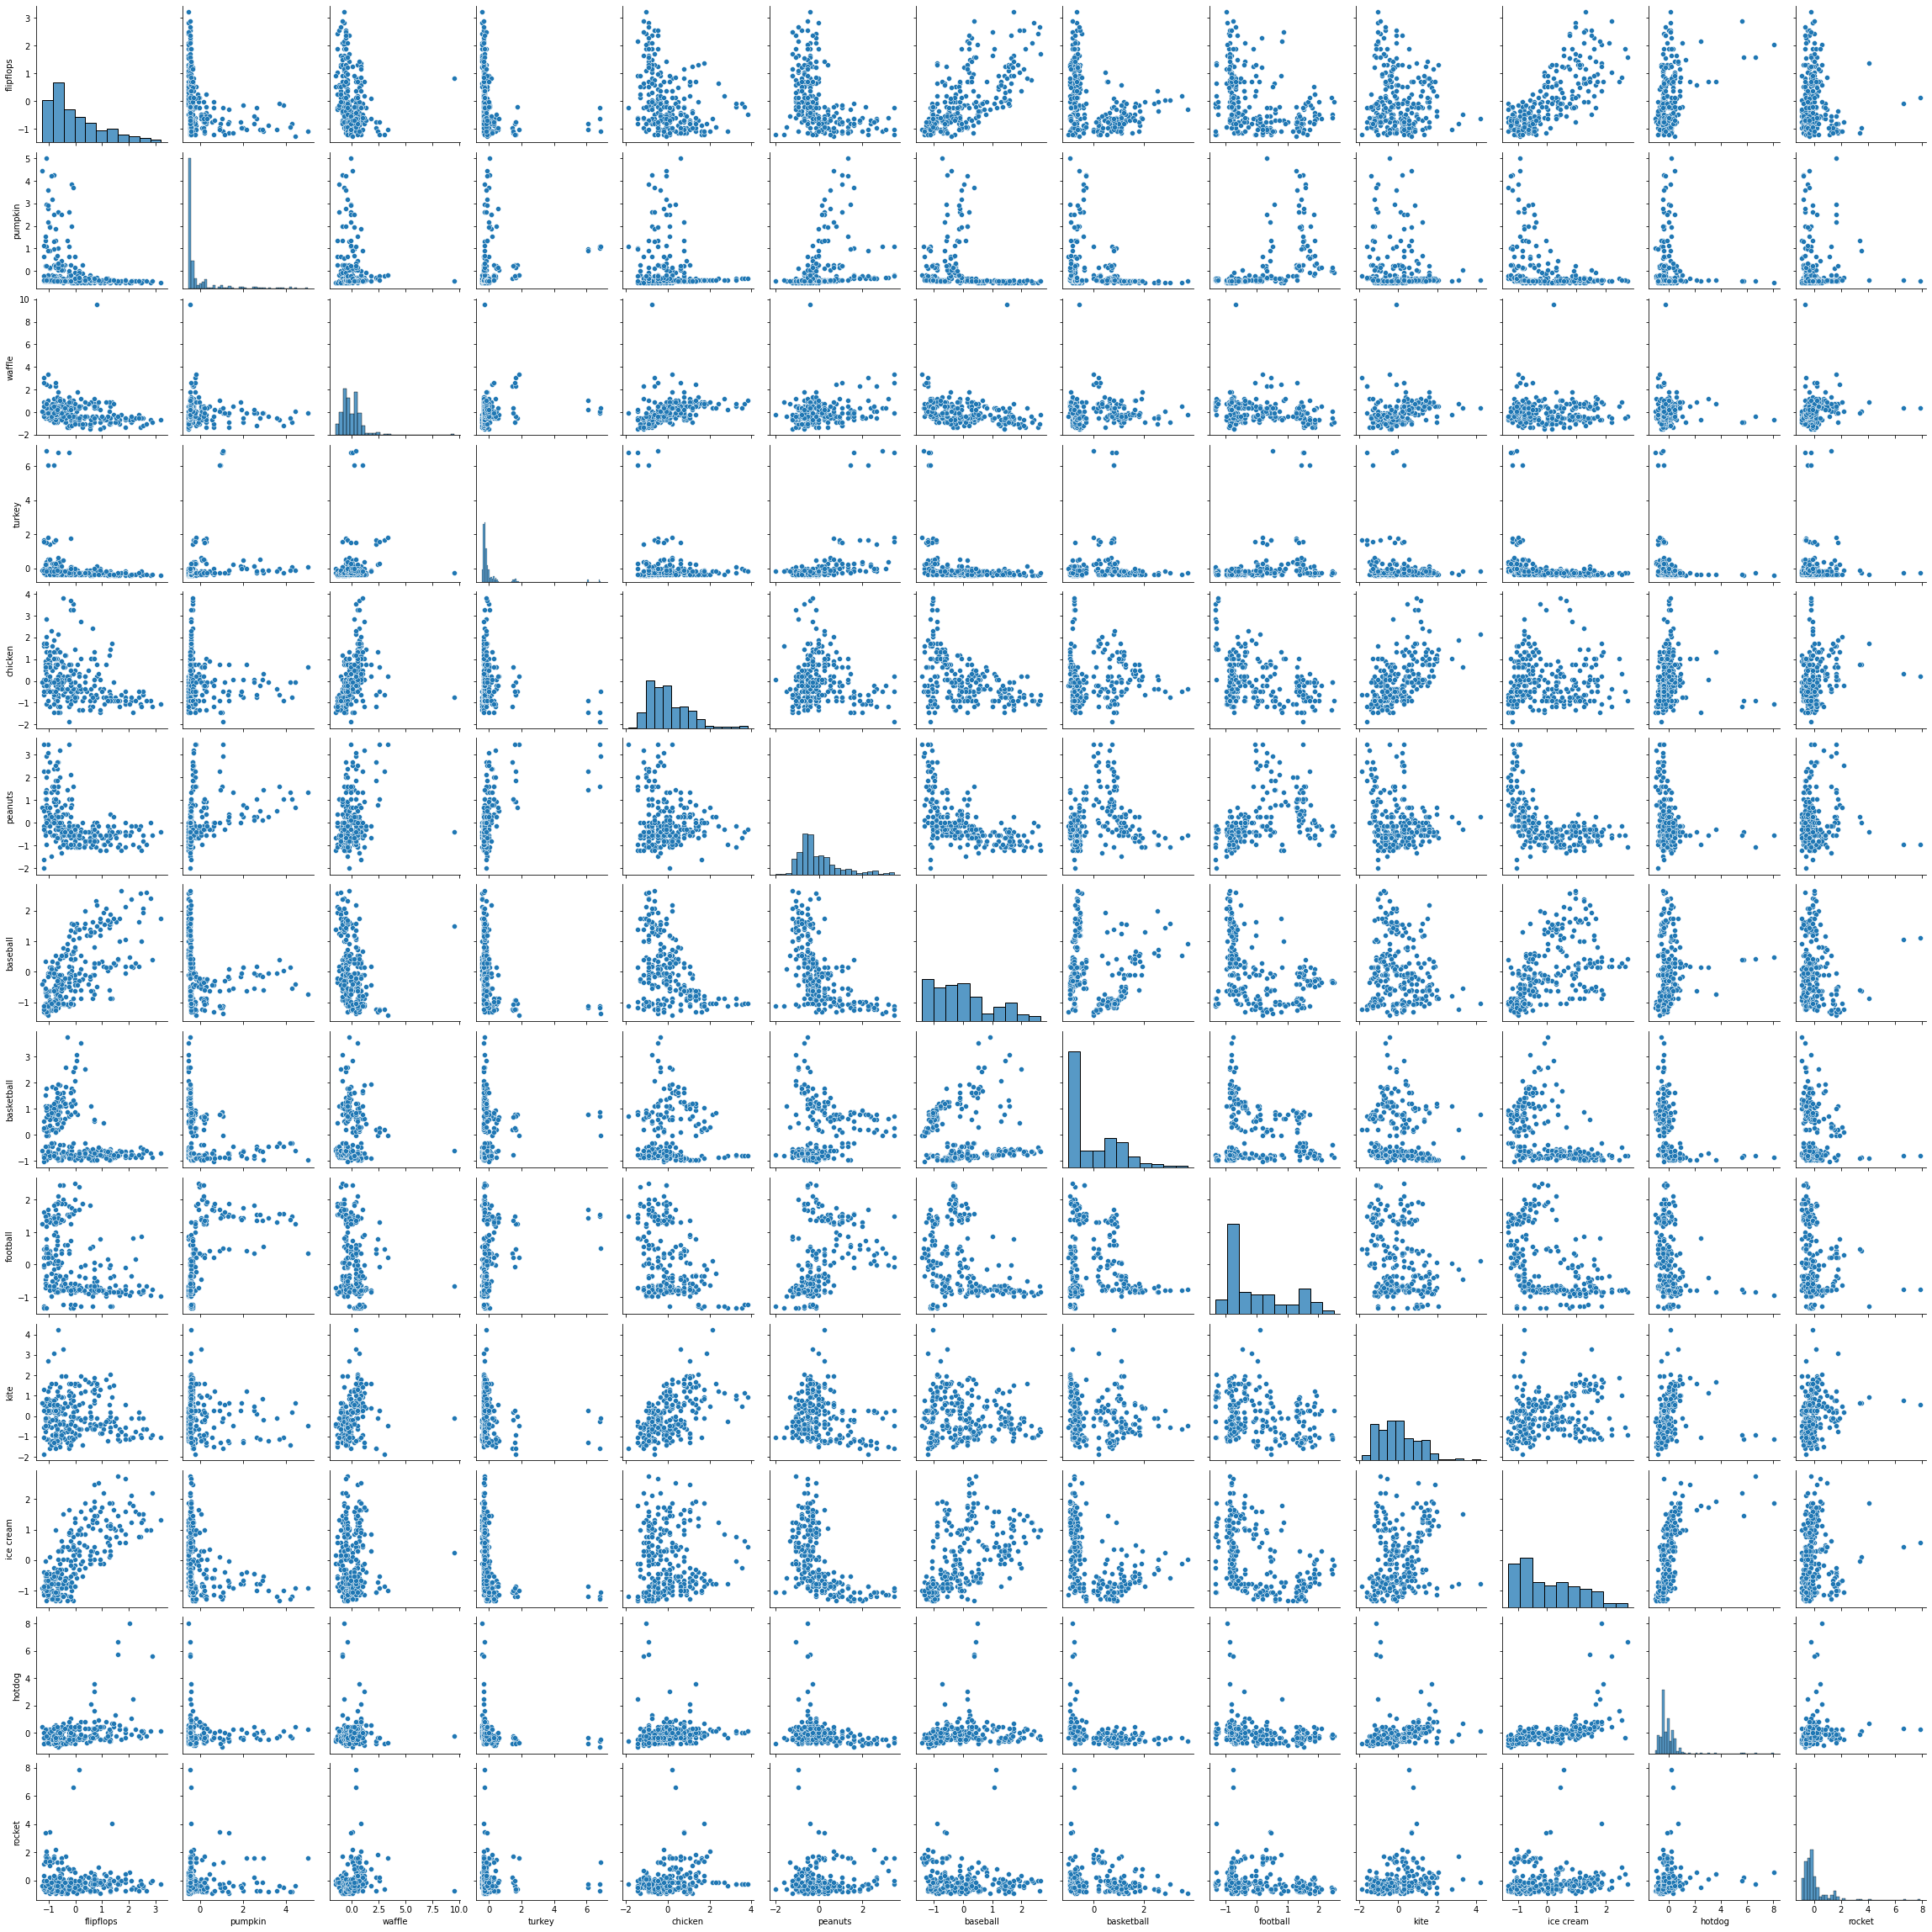

In [15]:
seaborn.pairplot(df_agg)